In [2]:
import zipfile

zip_path = "C:/Users/padmavathi/solar_demo/archive.zip"
extract_to = "C:/Users/padmavathi/solar_demo/chest_xray_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Dataset extracted successfully!")


✅ Dataset extracted successfully!


In [5]:
import os

def count_images_in_directory(directory):
    count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                count += 1
    return count

base_path = "C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray"

train_count = count_images_in_directory(os.path.join(base_path, "train"))
val_count = count_images_in_directory(os.path.join(base_path, "val"))
test_count = count_images_in_directory(os.path.join(base_path, "test"))

print(f"📁 Train images: {train_count}")
print(f"📁 Validation images: {val_count}")
print(f"📁 Test images: {test_count}")
print(f"📸 Total images: {train_count + val_count + test_count}")


📁 Train images: 5216
📁 Validation images: 16
📁 Test images: 624
📸 Total images: 5856


Epoch 1/50, Train Acc: 96.49%, Val Acc: 100.00%
✅ Best model saved with val acc: 100.0
Epoch 2/50, Train Acc: 99.12%, Val Acc: 81.25%
Epoch 3/50, Train Acc: 99.58%, Val Acc: 100.00%
Epoch 4/50, Train Acc: 99.71%, Val Acc: 100.00%
Epoch 5/50, Train Acc: 99.65%, Val Acc: 75.00%
Epoch 6/50, Train Acc: 99.75%, Val Acc: 62.50%
Epoch 7/50, Train Acc: 99.92%, Val Acc: 75.00%
Epoch 8/50, Train Acc: 99.94%, Val Acc: 100.00%
Epoch 9/50, Train Acc: 99.98%, Val Acc: 100.00%
Epoch 10/50, Train Acc: 100.00%, Val Acc: 93.75%
Epoch 11/50, Train Acc: 99.21%, Val Acc: 87.50%
Epoch 12/50, Train Acc: 99.77%, Val Acc: 81.25%
Epoch 13/50, Train Acc: 99.88%, Val Acc: 100.00%
Epoch 14/50, Train Acc: 99.42%, Val Acc: 100.00%
Epoch 15/50, Train Acc: 99.94%, Val Acc: 100.00%
Epoch 16/50, Train Acc: 99.92%, Val Acc: 100.00%
Epoch 17/50, Train Acc: 100.00%, Val Acc: 100.00%
Epoch 18/50, Train Acc: 100.00%, Val Acc: 100.00%
Epoch 19/50, Train Acc: 100.00%, Val Acc: 100.00%
Epoch 20/50, Train Acc: 100.00%, Val Acc: 

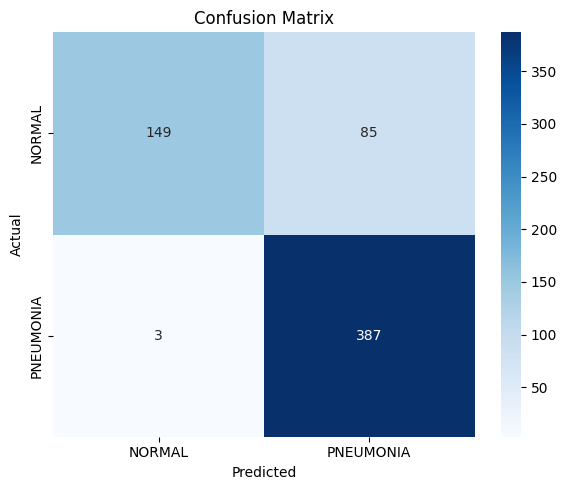

In [6]:
# pneumonia_training.ipynb (updated for 50 epochs with best model saving)

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
base_dir = "C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets & Loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

# Model: ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 50
best_val_acc = 0.0
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved with val acc:", best_val_acc)

# Test Evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [7]:
torch.save(model.state_dict(), "pneumonia_model.pth")
print("✅ Final model saved!")


✅ Final model saved!


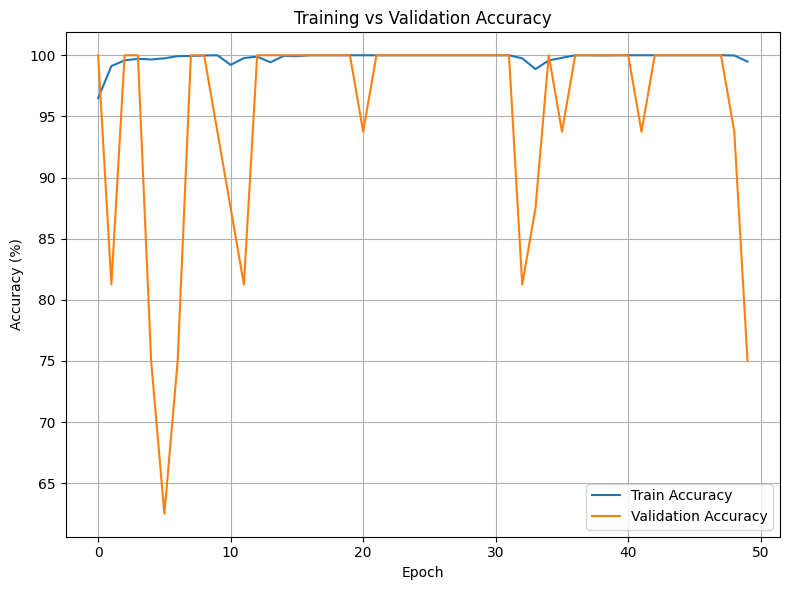

In [10]:
# 📈 Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_performance.png")  # Optional for Streamlit
plt.show()


📈 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.64      0.77       234
   PNEUMONIA       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624



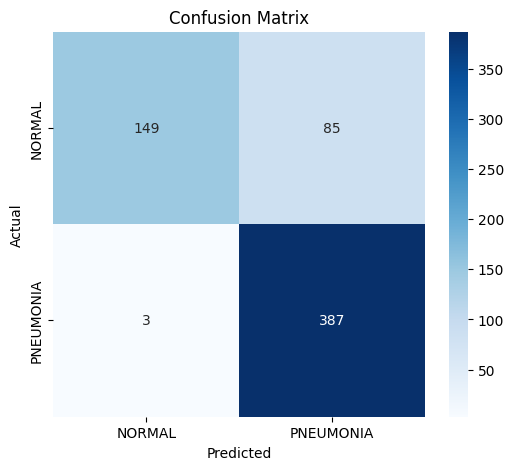

In [8]:
model.load_state_dict(torch.load("pneumonia_model.pth"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("📈 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [9]:
import os

base_dir = "C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray"

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.startswith("._") or file == ".DS_Store":
            try:
                os.remove(os.path.join(root, file))
                print(f"❌ Removed hidden file: {file}")
            except Exception as e:
                print(f"Error deleting {file}: {e}")


❌ Removed hidden file: .DS_Store
❌ Removed hidden file: .DS_Store
❌ Removed hidden file: .DS_Store
❌ Removed hidden file: .DS_Store
❌ Removed hidden file: .DS_Store
❌ Removed hidden file: .DS_Store
❌ Removed hidden file: .DS_Store
❌ Removed hidden file: .DS_Store
❌ Removed hidden file: ._chest_xray
❌ Removed hidden file: ._.DS_Store
❌ Removed hidden file: ._test
❌ Removed hidden file: ._train
❌ Removed hidden file: ._.DS_Store
❌ Removed hidden file: ._NORMAL
❌ Removed hidden file: ._PNEUMONIA
❌ Removed hidden file: ._IM-0001-0001.jpeg
❌ Removed hidden file: ._IM-0003-0001.jpeg
❌ Removed hidden file: ._IM-0005-0001.jpeg
❌ Removed hidden file: ._IM-0006-0001.jpeg
❌ Removed hidden file: ._IM-0007-0001.jpeg
❌ Removed hidden file: ._IM-0009-0001.jpeg
❌ Removed hidden file: ._IM-0010-0001.jpeg
❌ Removed hidden file: ._IM-0011-0001-0001.jpeg
❌ Removed hidden file: ._IM-0011-0001-0002.jpeg
❌ Removed hidden file: ._IM-0011-0001.jpeg
❌ Removed hidden file: ._IM-0013-0001.jpeg
❌ Removed hidden fi

In [11]:
import os
import hashlib

def find_duplicate_images(folder_path):
    hash_dict = {}
    duplicates = []

    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)

            # Only process image types
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    with open(file_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()

                    if file_hash in hash_dict:
                        duplicates.append((file_path, hash_dict[file_hash]))
                    else:
                        hash_dict[file_hash] = file_path
                except Exception as e:
                    print(f"⚠️ Could not read {file_path}: {e}")

    return duplicates

# Example usage:
folder = "C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray"
dups = find_duplicate_images(folder)

print(f"🔎 Found {len(dups)} duplicate image pairs.")
for dup in dups:
    print(f"\n🖼️ {dup[0]}\n📋 DUPLICATE OF: {dup[1]}")


🔎 Found 5888 duplicate image pairs.

🖼️ C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray\chest_xray\test\NORMAL\NORMAL2-IM-0096-0001.jpeg
📋 DUPLICATE OF: C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray\chest_xray\test\NORMAL\NORMAL2-IM-0095-0001.jpeg

🖼️ C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray\chest_xray\test\NORMAL\NORMAL2-IM-0173-0001-0002.jpeg
📋 DUPLICATE OF: C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray\chest_xray\test\NORMAL\NORMAL2-IM-0173-0001-0001.jpeg

🖼️ C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray\chest_xray\test\NORMAL\NORMAL2-IM-0246-0001-0002.jpeg
📋 DUPLICATE OF: C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray\chest_xray\test\NORMAL\NORMAL2-IM-0246-0001-0001.jpeg

🖼️ C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray\chest_xray\test\PNEUMONIA\person128_bacteria_607.jpeg
📋 DUPLICATE OF: C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray\chest_xray\t

In [12]:
import os

base_dir = r"C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray"

for root, _, files in os.walk(base_dir):
    for file in files:
        if file.startswith("._") or file == ".DS_Store":
            try:
                path = os.path.join(root, file)
                os.remove(path)
                print(f"🗑️ Deleted: {path}")
            except Exception as e:
                print(f"⚠️ Could not delete {file}: {e}")


Epoch 1/50, Train Acc: 96.84%, Val Acc: 100.00%
✅ Best model saved.
Epoch 2/50, Train Acc: 99.37%, Val Acc: 93.75%
Epoch 3/50, Train Acc: 99.83%, Val Acc: 93.75%
Epoch 4/50, Train Acc: 99.64%, Val Acc: 100.00%
Epoch 5/50, Train Acc: 99.65%, Val Acc: 87.50%
Epoch 6/50, Train Acc: 99.92%, Val Acc: 100.00%
Epoch 7/50, Train Acc: 99.79%, Val Acc: 100.00%
Epoch 8/50, Train Acc: 99.81%, Val Acc: 100.00%
Epoch 9/50, Train Acc: 99.87%, Val Acc: 100.00%
Epoch 10/50, Train Acc: 99.98%, Val Acc: 100.00%
Epoch 11/50, Train Acc: 99.69%, Val Acc: 100.00%
Epoch 12/50, Train Acc: 99.85%, Val Acc: 100.00%
Epoch 13/50, Train Acc: 99.87%, Val Acc: 93.75%
Epoch 14/50, Train Acc: 99.98%, Val Acc: 93.75%
Epoch 15/50, Train Acc: 100.00%, Val Acc: 100.00%
Epoch 16/50, Train Acc: 100.00%, Val Acc: 100.00%
Epoch 17/50, Train Acc: 100.00%, Val Acc: 100.00%
Epoch 18/50, Train Acc: 100.00%, Val Acc: 100.00%
Epoch 19/50, Train Acc: 100.00%, Val Acc: 100.00%
Epoch 20/50, Train Acc: 100.00%, Val Acc: 100.00%
Epoch 21

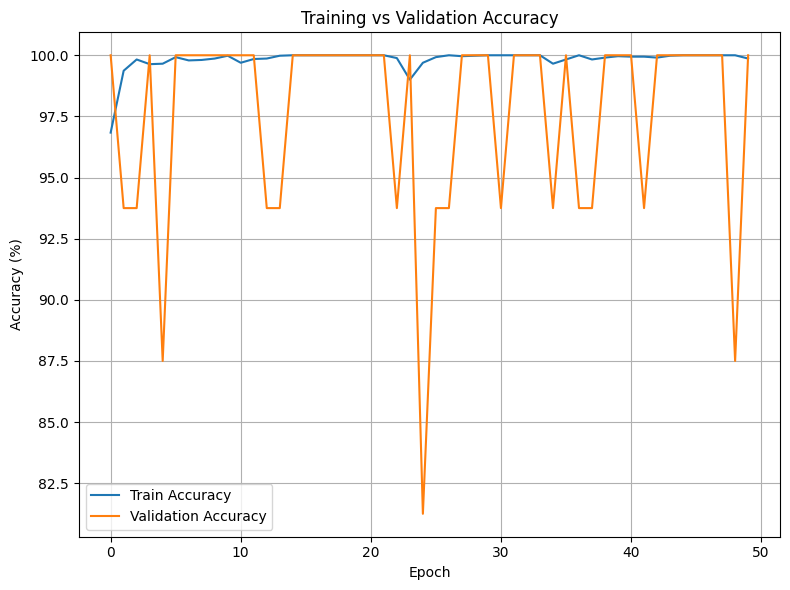

📈 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.34      0.51       234
   PNEUMONIA       0.72      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.85      0.67      0.67       624
weighted avg       0.82      0.75      0.71       624



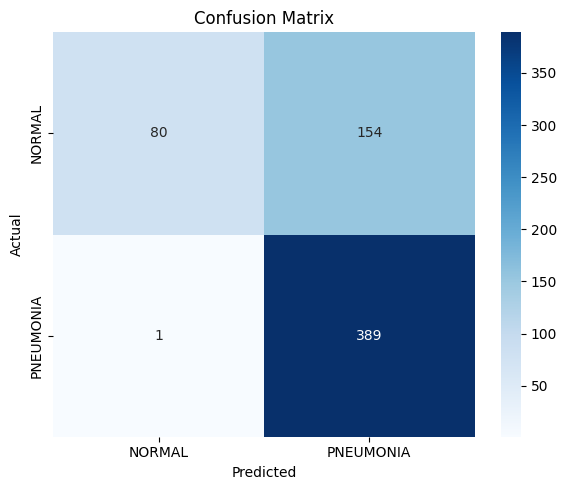

In [14]:
# 📌 Required Libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ✅ Paths
base_dir = r"C:/Users/padmavathi/solar_demo/chest_xray_extracted/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

# ✅ Transformations (Resize + Normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Image resize
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Datasets & Dataloaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

# ✅ Model: ResNet18 (Transfer Learning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: Pneumonia, Normal
model.to(device)

# ✅ Loss + Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ✅ Training Loop
num_epochs = 50
best_val_acc = 0.0
train_acc_list, val_acc_list = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)

    # ✅ Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # ✅ Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "pneumonia_model.pth")
        print("✅ Best model saved.")

# ✅ Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_performance.png")
plt.show()

# ✅ Evaluate on Test Set
model.load_state_dict(torch.load("pneumonia_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ✅ Classification Report
print("📈 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


In [1]:
pip install datasets


  Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl.metadata (13 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl (30 kB)
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from datasets import load_dataset

# Automatically downloads and loads the dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Show dataset structure
print(dataset)

# Preview a sample
print(dataset['train'][0]['text'])


c:\Users\padmavathi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\padmavathi\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\madhugula padmavathi\.cache\huggingface\hub\datasets--wikitext. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article:

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})



In [3]:
pip install datasets nltk torch


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------------- ------------------- 0.8/1.5 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to C:\Users\madhugula
[nltk_data]     padmavathi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
.... 2nd project

In [8]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Download tokenizer
nltk.download("punkt")

# Set huggingface dataset cache to project folder
os.environ["HF_DATASETS_CACHE"] = "C:/Users/padmavathi/solar_demo/hf_datasets"


[nltk_data] Downloading package punkt to C:\Users\madhugula
[nltk_data]     padmavathi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
2nd project

In [2]:
pip install ipywidgets

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 50.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from datasets import load_dataset

# Load WikiText-2 from Hugging Face
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Save to your project path
save_path = "C:/Users/padmavathi/solar_demo"

for split in ['train', 'validation', 'test']:
    with open(f"{save_path}/wikitext2_{split}.txt", "w", encoding="utf-8") as f:
        for row in dataset[split]:
            f.write(row['text'] + '\n')


In [1]:
# ✅ Safe NLTK punkt setup
import nltk
import os

nltk_data_path = r"C:/Users/padmavathi/solar_demo/nltk_data"
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)

# Check if punkt already exists
punkt_path = os.path.join(nltk_data_path, "tokenizers", "punkt")
if not os.path.exists(punkt_path):
    print("📥 Downloading 'punkt' tokenizer...")
    nltk.download("punkt", download_dir=nltk_data_path)
else:
    print("✅ 'punkt' tokenizer already exists at:", punkt_path)


✅ 'punkt' tokenizer already exists at: C:/Users/padmavathi/solar_demo/nltk_data\tokenizers\punkt


In [4]:
import nltk
import os

# ✅ Path to your nltk_data
nltk_data_path = r"C:/Users/padmavathi/solar_demo/nltk_data"
os.makedirs(nltk_data_path, exist_ok=True)

# ✅ Download both punkt and punkt_tab
nltk.download('punkt', download_dir=nltk_data_path, force=True)
nltk.download('punkt_tab', download_dir=nltk_data_path, force=True)

# ✅ Force nltk to use this path only
nltk.data.path.clear()
nltk.data.path.append(nltk_data_path)

# 🔍 Test again
from nltk.tokenize import word_tokenize
print("✅ Tokenizer Test:", word_tokenize("Hello, this is a tokenizer test!"))


[nltk_data] Downloading package punkt to
[nltk_data]     C:/Users/padmavathi/solar_demo/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:/Users/padmavathi/solar_demo/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


✅ Tokenizer Test: ['Hello', ',', 'this', 'is', 'a', 'tokenizer', 'test', '!']


In [5]:
# 📘 Day 1 - Next Word Prediction (Dataset Loading & Preprocessing)

# ✅ Imports
import os
import random
import pickle
import numpy as np
import torch
from datasets import load_dataset
import nltk
from nltk.tokenize import word_tokenize

# ✅ Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ✅ Ensure punkt is available in your custom path
nltk_data_path = r"C:/Users/padmavathi/solar_demo/nltk_data"
nltk.data.path.append(nltk_data_path)

# Test tokenizer (should work now)
print("🔍 Tokenizer test:", word_tokenize("Hello, this is a tokenizer test!"))

# ✅ Load WikiText-2 dataset
print("\n📥 Loading WikiText-2 dataset...")
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
print(dataset)

# ✅ Explore data
print("\n📝 First training example:\n", dataset["train"][0]["text"])

# ✅ Preprocessing (Tokenization + Lowercasing)
print("\n🔄 Tokenizing and preparing sequences...")
train_text = " ".join([x["text"] for x in dataset["train"]])
val_text = " ".join([x["text"] for x in dataset["validation"]])

train_tokens = word_tokenize(train_text.lower())
val_tokens = word_tokenize(val_text.lower())

print(f"✅ Training tokens: {len(train_tokens)} | Validation tokens: {len(val_tokens)}")

# ✅ Build vocabulary
print("\n🔤 Building vocabulary...")
vocab = sorted(set(train_tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
print(f"✅ Vocabulary size: {len(vocab)}")

# ✅ Save vocabulary for later use
vocab_path = r"C:/Users/padmavathi/solar_demo/vocab.pkl"
with open(vocab_path, "wb") as f:
    pickle.dump((word2idx, idx2word), f)
print(f"💾 Vocabulary saved to: {vocab_path}")

# ✅ Encode tokens
def encode_tokens(tokens):
    return [word2idx[token] for token in tokens if token in word2idx]

train_encoded = encode_tokens(train_tokens)
val_encoded = encode_tokens(val_tokens)
print(f"🔢 Encoded train length: {len(train_encoded)} | Encoded val length: {len(val_encoded)}")

# ✅ Save encoded sequences for Day 2
np.save(r"C:/Users/padmavathi/solar_demo/train_encoded.npy", train_encoded)
np.save(r"C:/Users/padmavathi/solar_demo/val_encoded.npy", val_encoded)
print("💾 Encoded data saved successfully.")


🔍 Tokenizer test: ['Hello', ',', 'this', 'is', 'a', 'tokenizer', 'test', '!']

📥 Loading WikiText-2 dataset...
DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

📝 First training example:
 

🔄 Tokenizing and preparing sequences...
✅ Training tokens: 2098683 | Validation tokens: 219046

🔤 Building vocabulary...
✅ Vocabulary size: 66564
💾 Vocabulary saved to: C:/Users/padmavathi/solar_demo/vocab.pkl
🔢 Encoded train length: 2098683 | Encoded val length: 212635
💾 Encoded data saved successfully.


In [7]:
# ✅ Imports
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# ✅ Load preprocessed data from Day 1
train_encoded = np.load(r"C:/Users/padmavathi/solar_demo/train_encoded.npy", allow_pickle=True)
val_encoded = np.load(r"C:/Users/padmavathi/solar_demo/val_encoded.npy", allow_pickle=True)

print(f"✅ Train encoded length: {len(train_encoded)} | Validation encoded length: {len(val_encoded)}")

# ✅ Load vocabulary
import pickle
with open(r"C:/Users/padmavathi/solar_demo/vocab.pkl", "rb") as f:
    word2idx, idx2word = pickle.load(f)

vocab_size = len(word2idx)
print(f"🔤 Vocabulary size: {vocab_size}")

# ✅ Sequence preparation
sequence_length = 20  # can tune (longer = more context)

def create_sequences(data, seq_len):
    inputs, targets = [], []
    for i in range(len(data) - seq_len):
        inputs.append(data[i:i+seq_len])
        targets.append(data[i+seq_len])
    return torch.tensor(inputs), torch.tensor(targets)

X_train, y_train = create_sequences(train_encoded, sequence_length)
X_val, y_val = create_sequences(val_encoded, sequence_length)

print(f"✅ Train sequences: {X_train.shape} | Val sequences: {X_val.shape}")

# ✅ Custom Dataset
class WordDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = WordDataset(X_train, y_train)
val_dataset = WordDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

print("✅ DataLoaders ready.")

# ✅ Model Definition (LSTM)
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=256, num_layers=2):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # prediction from last time step
        return out

# ✅ Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(vocab_size).to(device)
print(model)

print("\n✅ Model defined successfully.")


✅ Train encoded length: 2098683 | Validation encoded length: 212635
🔤 Vocabulary size: 66564
✅ Train sequences: torch.Size([2098663, 20]) | Val sequences: torch.Size([212615, 20])
✅ DataLoaders ready.
LSTMModel(
  (embedding): Embedding(66564, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=66564, bias=True)
)

✅ Model defined successfully.


⚡ Using device: cpu

🚀 Starting training...
📍 Epoch [1/30] | Train Loss: 6.2788 | Val Loss: 5.8765
📍 Epoch [2/30] | Train Loss: 5.7313 | Val Loss: 5.7113
📍 Epoch [3/30] | Train Loss: 5.4253 | Val Loss: 5.6484
📍 Epoch [4/30] | Train Loss: 5.2146 | Val Loss: 5.6407
📍 Epoch [5/30] | Train Loss: 5.0343 | Val Loss: 5.6758
📍 Epoch [6/30] | Train Loss: 4.8893 | Val Loss: 5.7458
📍 Epoch [7/30] | Train Loss: 4.7587 | Val Loss: 5.7960
📍 Epoch [8/30] | Train Loss: 4.6455 | Val Loss: 5.8616
📍 Epoch [9/30] | Train Loss: 4.5406 | Val Loss: 5.9025
📍 Epoch [10/30] | Train Loss: 4.4509 | Val Loss: 5.9823
📍 Epoch [11/30] | Train Loss: 4.3609 | Val Loss: 5.9988
📍 Epoch [12/30] | Train Loss: 4.2927 | Val Loss: 6.0685
📍 Epoch [13/30] | Train Loss: 4.2283 | Val Loss: 6.1211
📍 Epoch [14/30] | Train Loss: 4.1690 | Val Loss: 6.2155
📍 Epoch [15/30] | Train Loss: 4.1121 | Val Loss: 6.2990
📍 Epoch [16/30] | Train Loss: 4.0606 | Val Loss: 6.3323
📍 Epoch [17/30] | Train Loss: 4.0125 | Val Loss: 6.3601
📍 Epoch [18/3

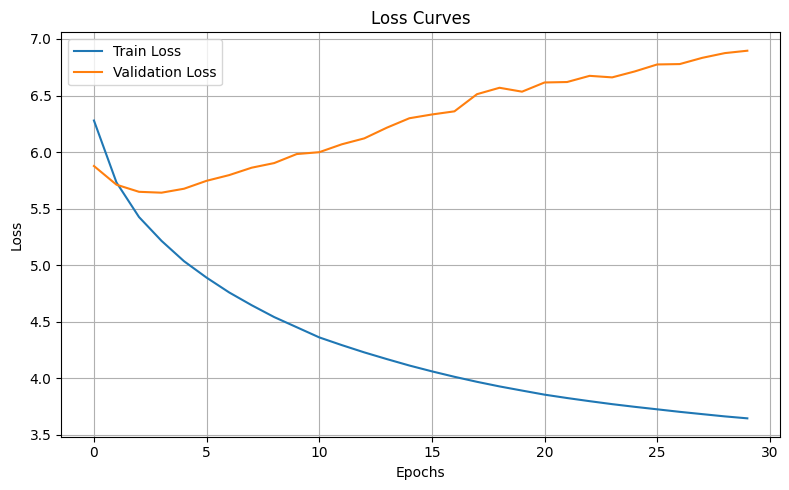


✅ Training complete. Model is ready.


In [8]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ✅ Load from Day 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("⚡ Using device:", device)

# ✅ Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ Training Loop
epochs = 30  # increase later (10–20 for better performance)
train_losses, val_losses = [], []

print("\n🚀 Starting training...")

for epoch in range(epochs):
    # 🔹 Training phase
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔹 Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"📍 Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# ✅ Save model
model_path = r"C:/Users/padmavathi/solar_demo/nextword_model.pth"
torch.save(model.state_dict(), model_path)
print(f"\n💾 Model saved to: {model_path}")

# ✅ Plot Loss Curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:/Users/padmavathi/solar_demo/loss_curve.png")
plt.show()

print("\n✅ Training complete. Model is ready.")


In [1]:
# 📘 Day 4: Model Evaluation + Text Generation

import torch
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt

# ✅ Paths
model_path = r"C:/Users/padmavathi/solar_demo/nextword_model.pth"
vocab_path = r"C:/Users/padmavathi/solar_demo/vocab.pkl"

# ✅ Load vocabulary
with open(vocab_path, "rb") as f:
    word2idx, idx2word = pickle.load(f)

vocab_size = len(word2idx)

# ✅ Define same LSTM model (must match training!)
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=256, num_layers=2):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

# ✅ Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(vocab_size).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print("✅ Model loaded and ready for text generation.")

# ✅ Text generation function
def generate_text(seed_text, next_words=20):
    model.eval()
    words = seed_text.lower().split()
    state_h, state_c = None, None

    for _ in range(next_words):
        # Convert words to indices
        x = torch.tensor([[word2idx.get(w, 0) for w in words[-20:]]], dtype=torch.long).to(device)
        # Forward pass
        output, (state_h, state_c) = model.lstm(model.embedding(x), (state_h, state_c)) if state_h is not None else model.lstm(model.embedding(x))
        last_word_logits = model.fc(output[:, -1, :])
        p = torch.nn.functional.softmax(last_word_logits, dim=-1).cpu().detach().numpy()
        word_index = np.random.choice(len(word2idx), p=p[0])
        words.append(idx2word[word_index])

    return " ".join(words)

# ✅ Try generating some text
print("\n📝 Generated Text Sample 1:")
print(generate_text("the economy of india", next_words=20))

print("\n📝 Generated Text Sample 2:")
print(generate_text("artificial intelligence will", next_words=20))

print("\n📝 Generated Text Sample 3:")
print(generate_text("machine learning is", next_words=20))


✅ Model loaded and ready for text generation.

📝 Generated Text Sample 1:
the economy of india to settle its united states subordinate commercial interests , and major trails continued @ - @ up all the new

📝 Generated Text Sample 2:
artificial intelligence will vietnamese motor unit helicopters west . along the beach 's construction in colder division clashed with heavy pockets between the

📝 Generated Text Sample 3:
machine learning is , being an a woman by which he sings in order to have a `` look case `` that is


In [ ]:
3rd project

In [1]:
import zipfile
import os
import pandas as pd

# ✅ Path to your ZIP file
zip_path = r"C:/Users/padmavathi/solar_demo/archive (1).zip"
extract_to = r"C:/Users/padmavathi/solar_demo/superstore_data"

# ✅ Step 1: Extract zip contents
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extraction complete.")

# ✅ Step 2: Locate the CSV file (with space and dash in name)
csv_file_path = os.path.join(extract_to, "Sample - Superstore.csv")

# ✅ Step 3: Load CSV into DataFrame
df = pd.read_csv(csv_file_path, encoding='ISO-8859-1')  # encoding to avoid character errors

print("\n📄 First 5 rows of the dataset:")
print(df.head())

print("\n🔍 Dataset info:")
print(df.info())

print("\n📊 Summary statistics for numeric columns:")
print(df.describe())

print("\n🧾 Columns in dataset:")
print(df.columns.tolist())


✅ Extraction complete.

📄 First 5 rows of the dataset:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product I

In [3]:
import pandas as pd

# Correct path with proper quotes
csv_path = r"C:/Users/padmavathi/solar_demo/superstore_data/Sample - Superstore.csv"

# Load the CSV with encoding fix
df = pd.read_csv(csv_path, encoding='ISO-8859-1')

# Quick preview
print(df.shape)
print(df.columns)


(9994, 21)
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


In [5]:
import pandas as pd
import os

# ✅ CSV file path
csv_path = r"C:/Users/padmavathi/solar_demo/superstore_data/Sample - Superstore.csv"

# ✅ Load dataset
df = pd.read_csv(csv_path, encoding='ISO-8859-1')
print("✅ Dataset loaded.\n")

# ✅ 1. Preview shape and columns
print("🧾 Shape of data:", df.shape)
print("🧾 Columns:", df.columns.tolist())

# ✅ 2. Check for missing values
print("\n🔍 Missing Values:")
print(df.isnull().sum())

# ✅ 3. Drop rows with missing values
df_cleaned = df.dropna()
print("\n🧹 After dropping missing values, new shape:", df_cleaned.shape)

# ✅ 4. Drop duplicates
df_cleaned = df_cleaned.drop_duplicates()
print("🧼 After dropping duplicates:", df_cleaned.shape)

# ✅ 5. Convert date columns
df_cleaned['Order Date'] = pd.to_datetime(df_cleaned['Order Date'], format='%m/%d/%Y', errors='coerce')
df_cleaned['Ship Date'] = pd.to_datetime(df_cleaned['Ship Date'], format='%m/%d/%Y', errors='coerce')

# ✅ 6. Extract useful date parts
df_cleaned['Order Year'] = df_cleaned['Order Date'].dt.year
df_cleaned['Order Month'] = df_cleaned['Order Date'].dt.month_name()

# ✅ 7. Check for date parsing errors
print("\n📅 Date Conversion - Nulls After Parsing:")
print(df_cleaned[['Order Date', 'Ship Date']].isnull().sum())

# ✅ 8. Data types
print("\n🧾 Data Types After Cleaning:")
print(df_cleaned.dtypes)

# ✅ 9. Summary Statistics
print("\n📊 Summary Statistics:")
print(df_cleaned.describe())

# ✅ 10. Unique values in each column
print("\n🔢 Unique values per column:")
print(df_cleaned.nunique())

# ✅ 11. Preview cleaned data
print("\n✅ Cleaned Data Preview:")
print(df_cleaned.head())

# ✅ 12. Save cleaned data
cleaned_path = r"C:/Users/padmavathi/solar_demo/superstore_data/cleaned_superstore.csv"
os.makedirs(os.path.dirname(cleaned_path), exist_ok=True)
df_cleaned.to_csv(cleaned_path, index=False)
print(f"\n💾 Cleaned data saved to: {cleaned_path}")


✅ Dataset loaded.

🧾 Shape of data: (9994, 21)
🧾 Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']

🔍 Missing Values:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

🧹 After dropping missing values, new shape: (9994, 21)
🧼 After dropping duplicates: (9994, 21)

📅 Date Conversion - Nulls After Parsing:
Order Date    0
Ship Date     0
dtype: int64

🧾 Data Types After Cleaning:
Row ID                    int64
Order 

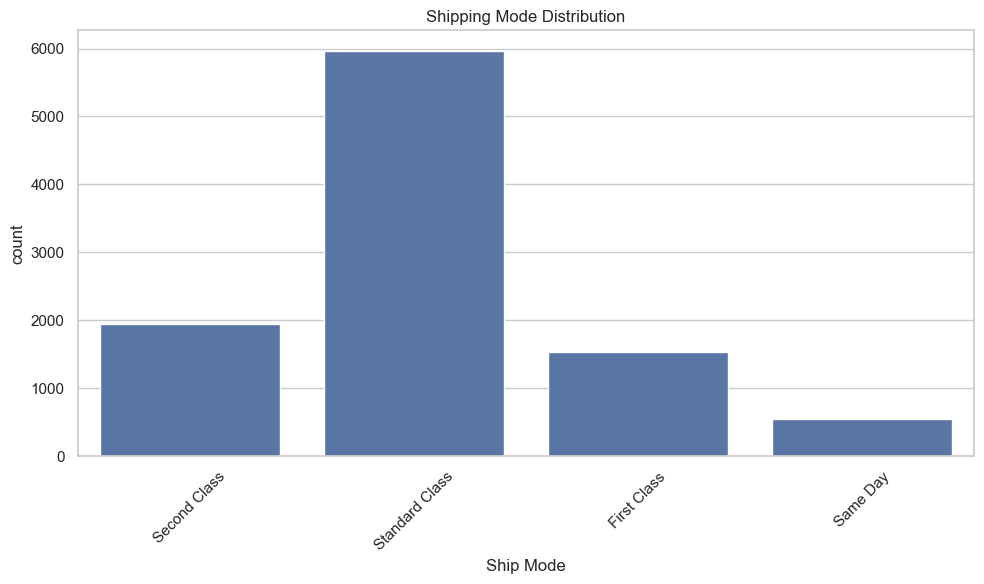

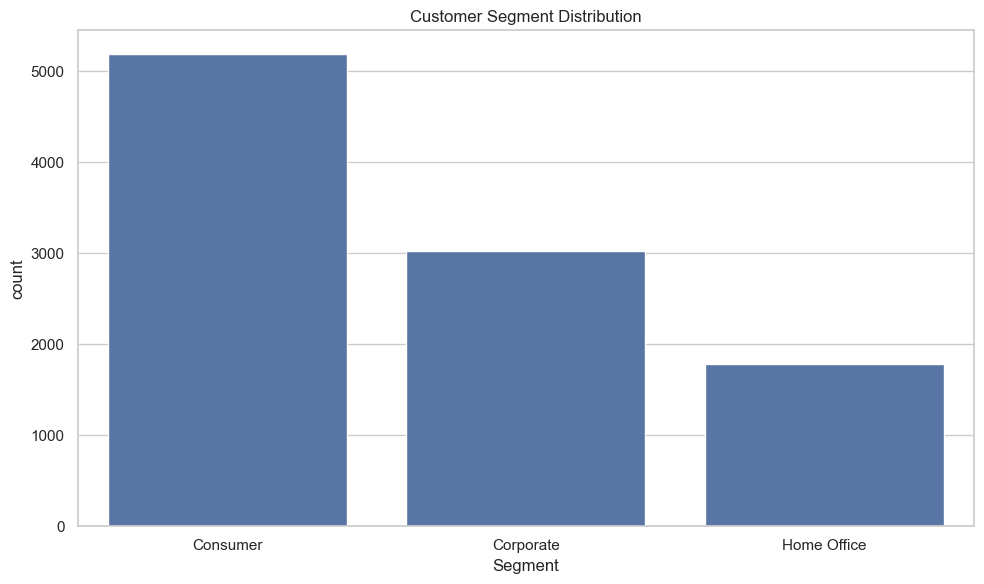

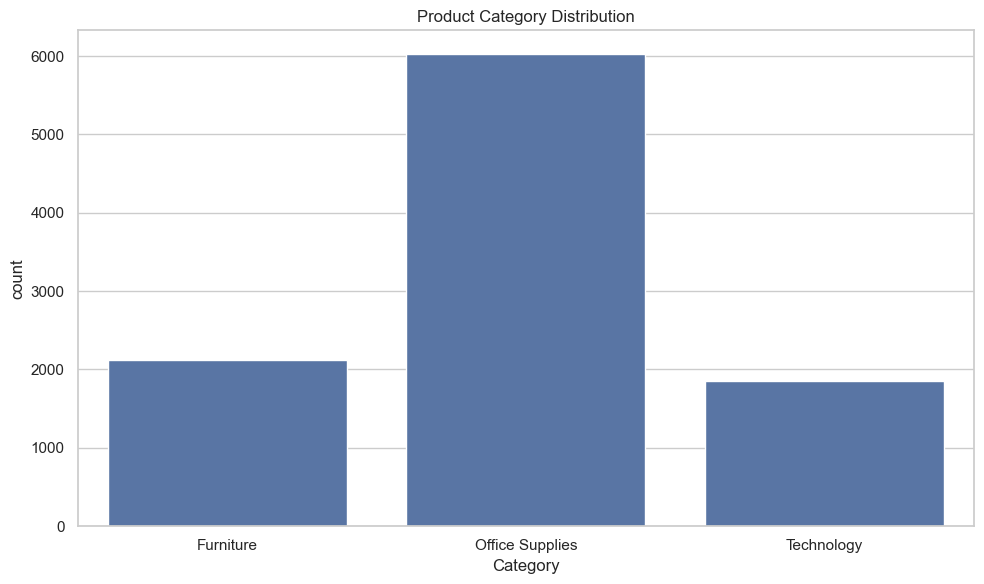

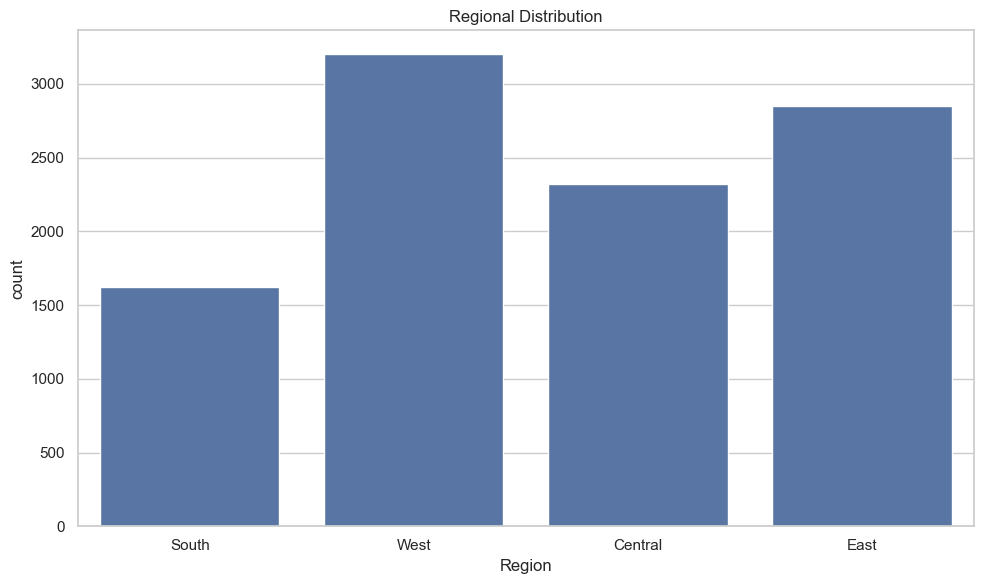

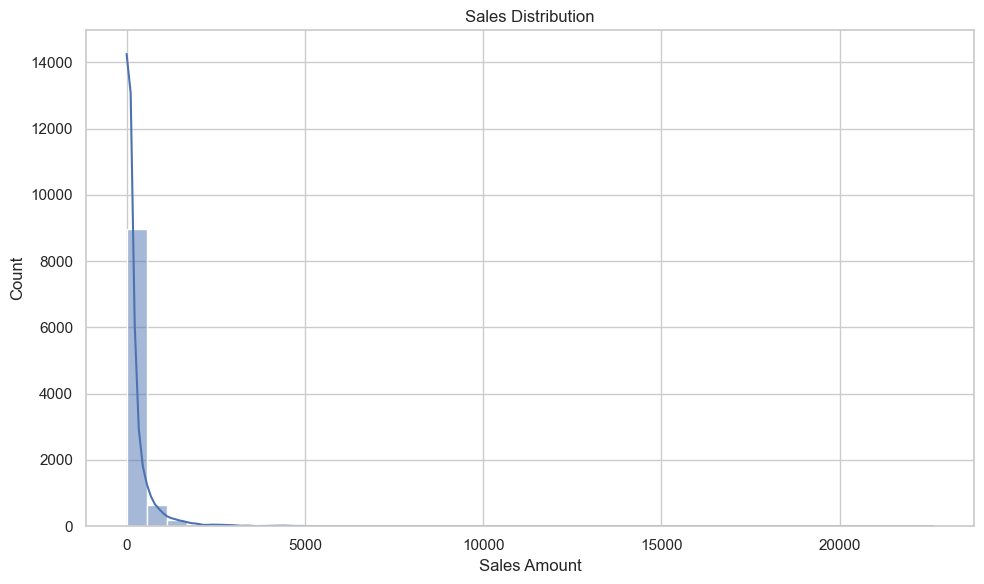

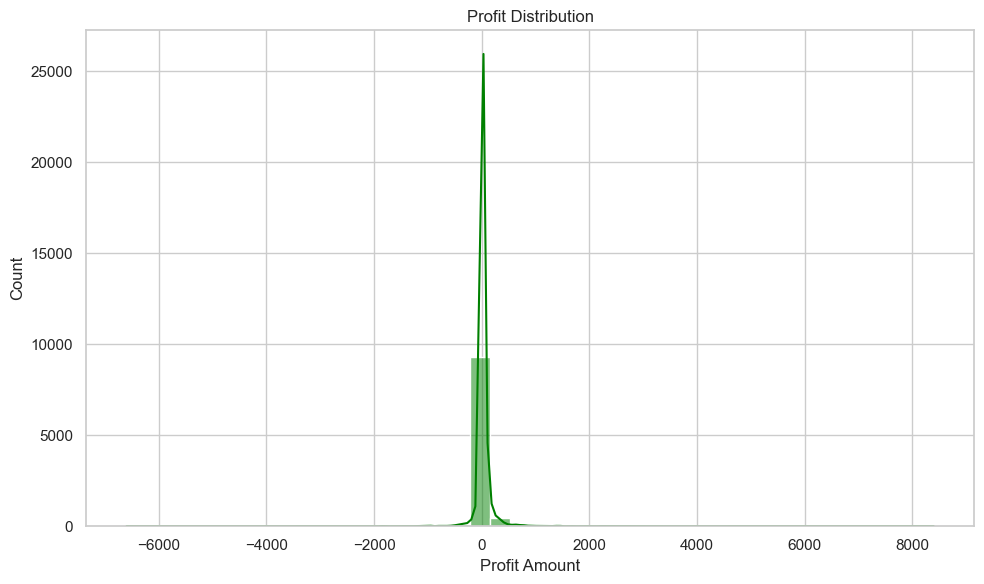

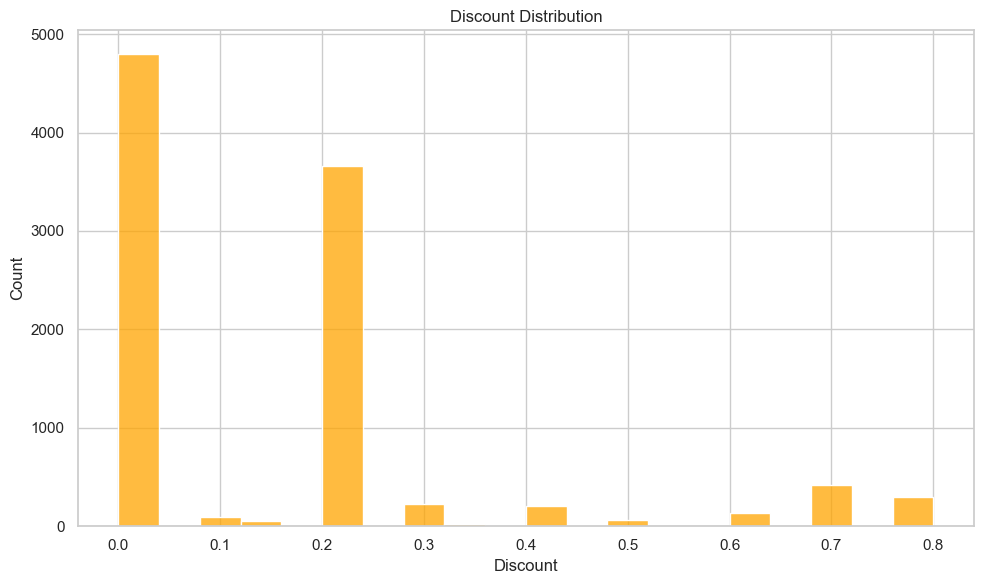

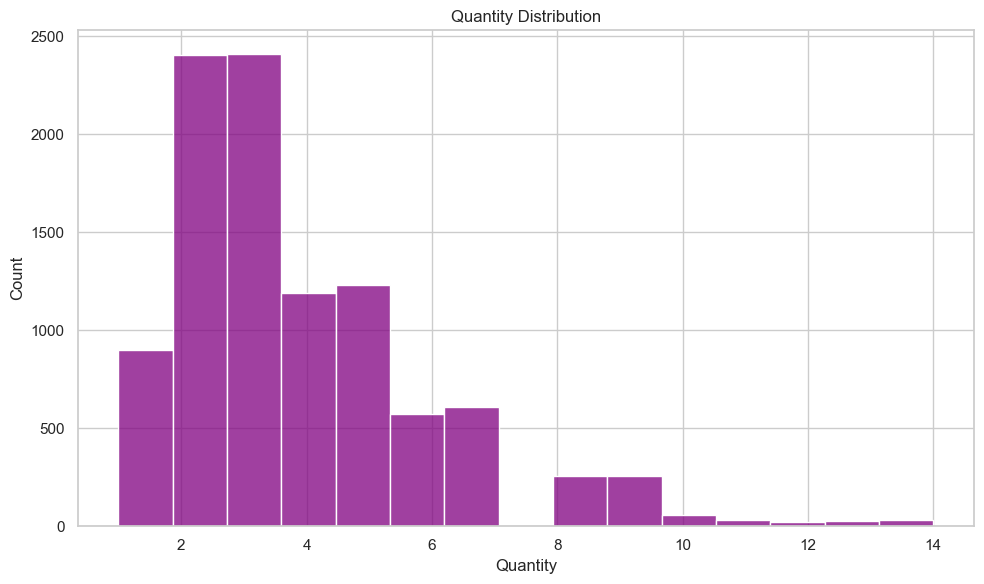

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 🔹 Bar plot - Ship Mode
sns.countplot(x='Ship Mode', data=df_cleaned)
plt.title('Shipping Mode Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 🔹 Bar plot - Segment
sns.countplot(x='Segment', data=df_cleaned)
plt.title('Customer Segment Distribution')
plt.tight_layout()
plt.show()

# 🔹 Bar plot - Category
sns.countplot(x='Category', data=df_cleaned)
plt.title('Product Category Distribution')
plt.tight_layout()
plt.show()

# 🔹 Bar plot - Region
sns.countplot(x='Region', data=df_cleaned)
plt.title('Regional Distribution')
plt.tight_layout()
plt.show()

# 🔹 Histogram - Sales
sns.histplot(df_cleaned['Sales'], bins=40, kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales Amount')
plt.tight_layout()
plt.show()

# 🔹 Histogram - Profit
sns.histplot(df_cleaned['Profit'], bins=40, kde=True, color='green')
plt.title('Profit Distribution')
plt.xlabel('Profit Amount')
plt.tight_layout()
plt.show()

# 🔹 Histogram - Discount
sns.histplot(df_cleaned['Discount'], bins=20, color='orange')
plt.title('Discount Distribution')
plt.xlabel('Discount')
plt.tight_layout()
plt.show()

# 🔹 Histogram - Quantity
sns.histplot(df_cleaned['Quantity'], bins=15, color='purple')
plt.title('Quantity Distribution')
plt.xlabel('Quantity')
plt.tight_layout()
plt.show()


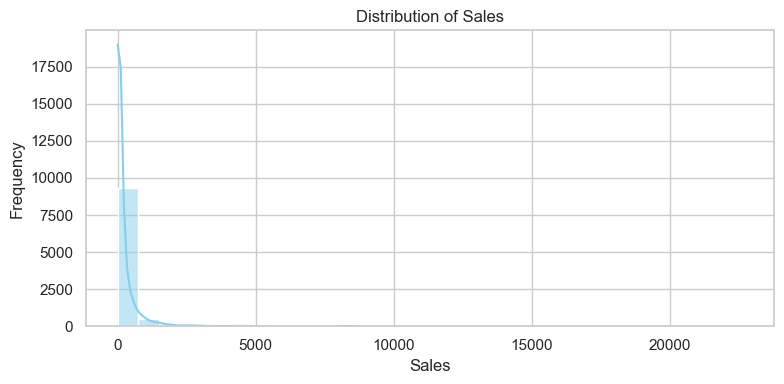

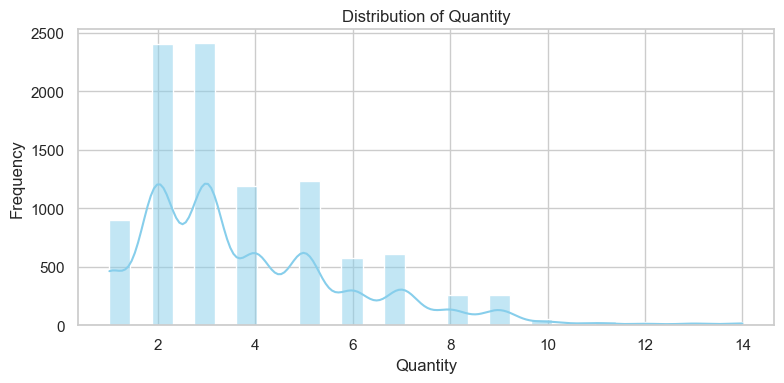

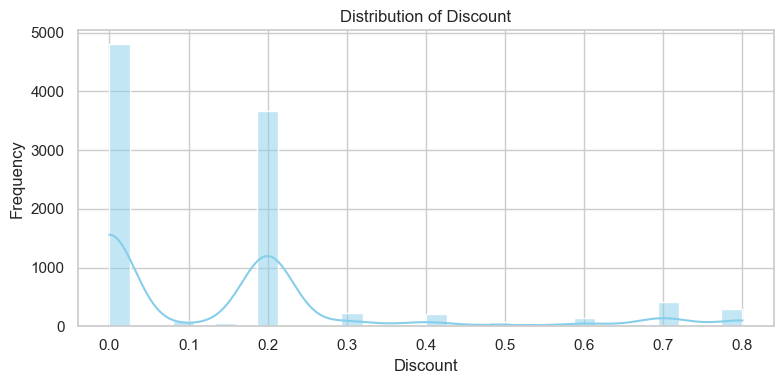

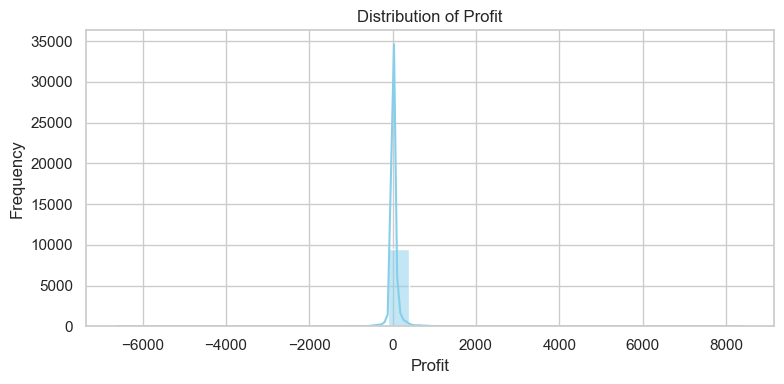

C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\2390217128.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2')


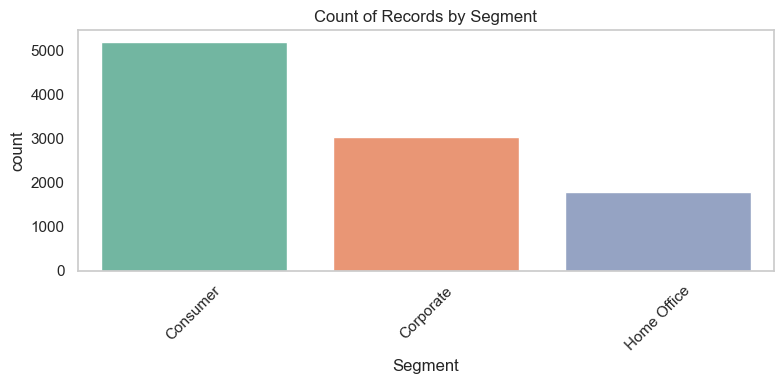

C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\2390217128.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2')


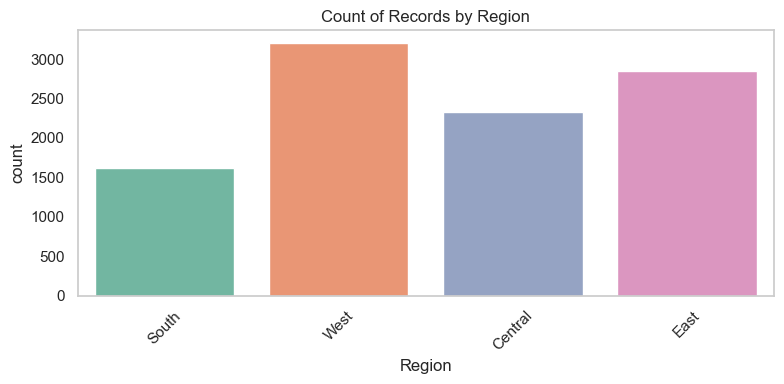

C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\2390217128.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2')


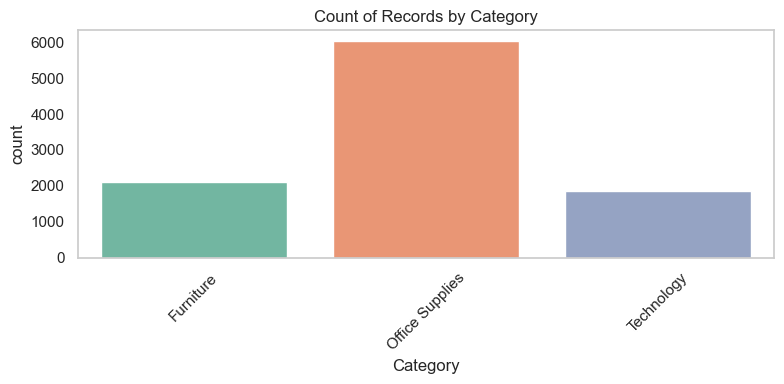

C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\2390217128.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2')


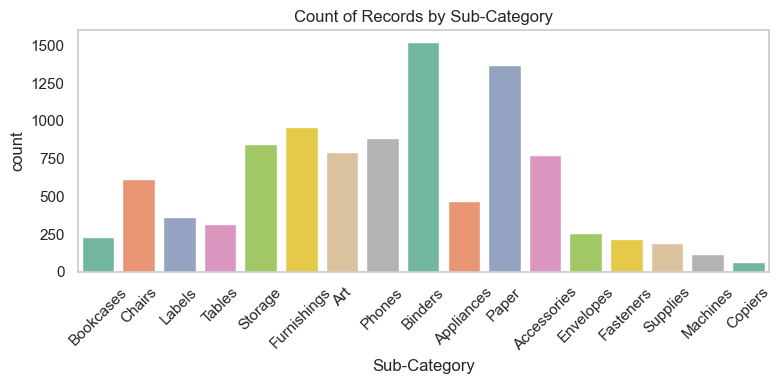

C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\2390217128.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Profit', palette='Pastel1')


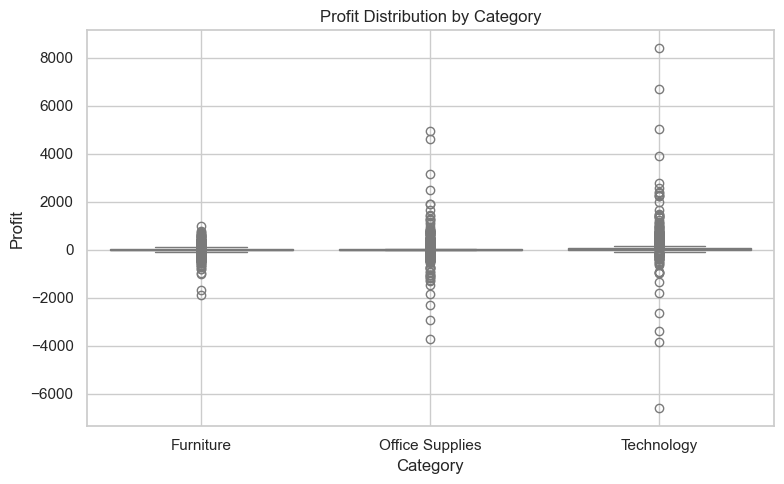

C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\2390217128.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Region', y='Sales', estimator=sum, ci=None, palette='muted')
C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\2390217128.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Region', y='Sales', estimator=sum, ci=None, palette='muted')


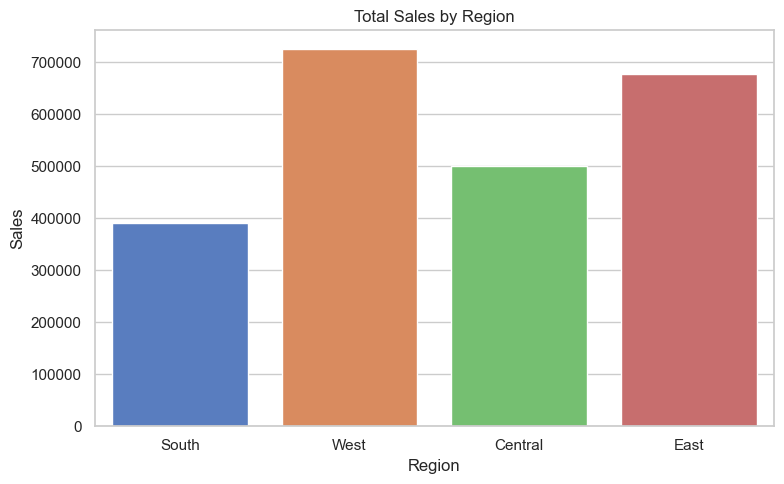

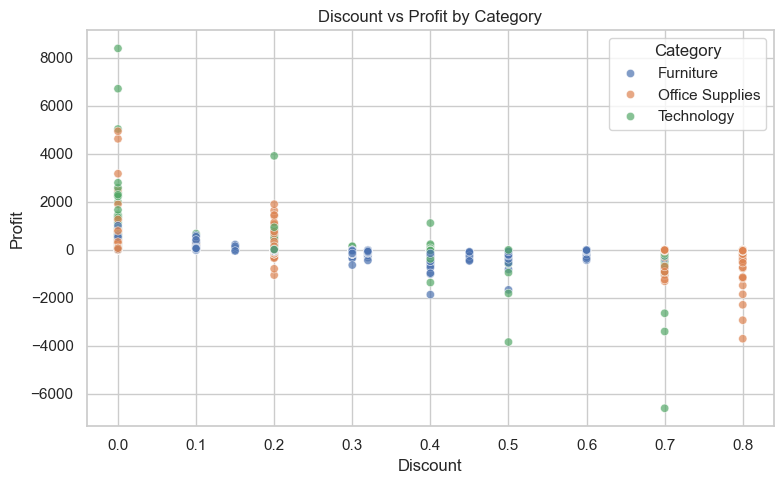

C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\2390217128.py:72: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Order Month', y='Sales', estimator=sum, ci=None, palette='coolwarm')
C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\2390217128.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Order Month', y='Sales', estimator=sum, ci=None, palette='coolwarm')


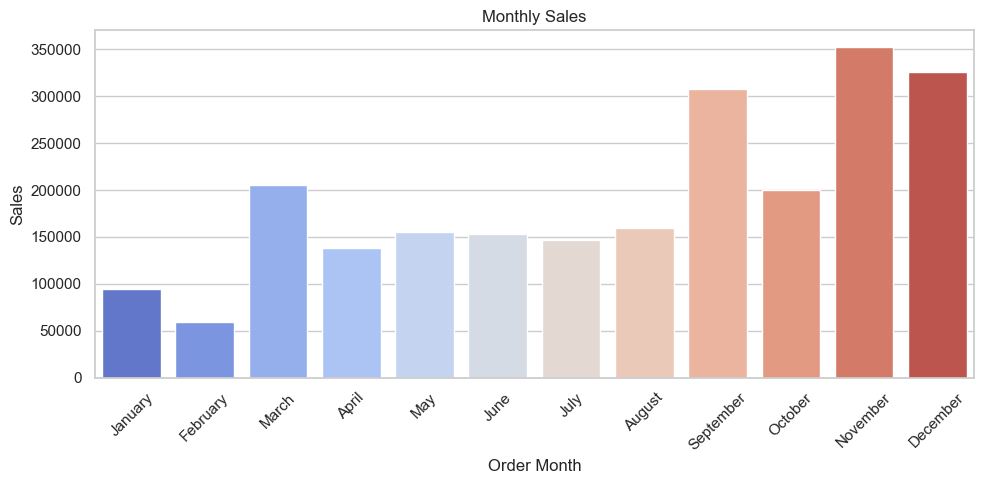


🔍 Key Univariate & Bivariate Visuals generated successfully!


In [7]:
# 📦 Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🧼 Load Cleaned Data
cleaned_path = r"C:/Users/padmavathi/solar_demo/superstore_data/cleaned_superstore.csv"
df = pd.read_csv(cleaned_path)

# 🗓️ Ensure 'Order Date' is datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

# 🧮 Add date parts for analysis
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month_name()

# 📊 Univariate Analysis: Numerical Columns
num_cols = ['Sales', 'Quantity', 'Discount', 'Profit']

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 📊 Univariate: Categorical Columns
cat_cols = ['Segment', 'Region', 'Category', 'Sub-Category']

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, palette='Set2')
    plt.title(f'Count of Records by {col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 📈 Bivariate Analysis: Category vs Profit
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Category', y='Profit', palette='Pastel1')
plt.title("Profit Distribution by Category")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Bivariate: Region vs Sales
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Region', y='Sales', estimator=sum, ci=None, palette='muted')
plt.title("Total Sales by Region")
plt.tight_layout()
plt.show()

# 📈 Bivariate: Discount vs Profit (Scatter)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Discount', y='Profit', hue='Category', alpha=0.7)
plt.title("Discount vs Profit by Category")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Bivariate: Order Month vs Sales
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']

df['Order Month'] = pd.Categorical(df['Order Month'], categories=month_order, ordered=True)

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Order Month', y='Sales', estimator=sum, ci=None, palette='coolwarm')
plt.title("Monthly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ Summary
print("\n🔍 Key Univariate & Bivariate Visuals generated successfully!")


C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\488400570.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\padmavathi\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


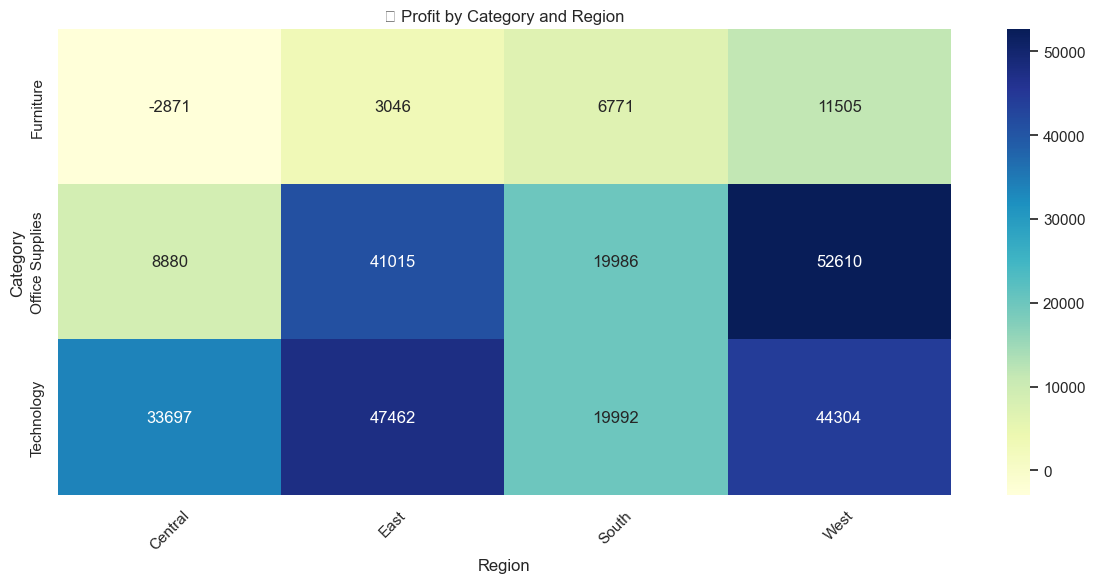

c:\Users\padmavathi\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


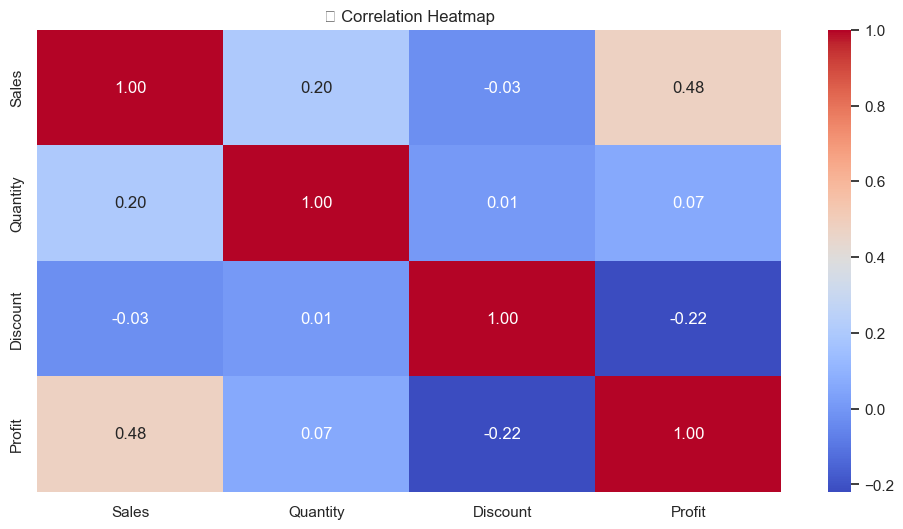

C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\488400570.py:43: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\padmavathi\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


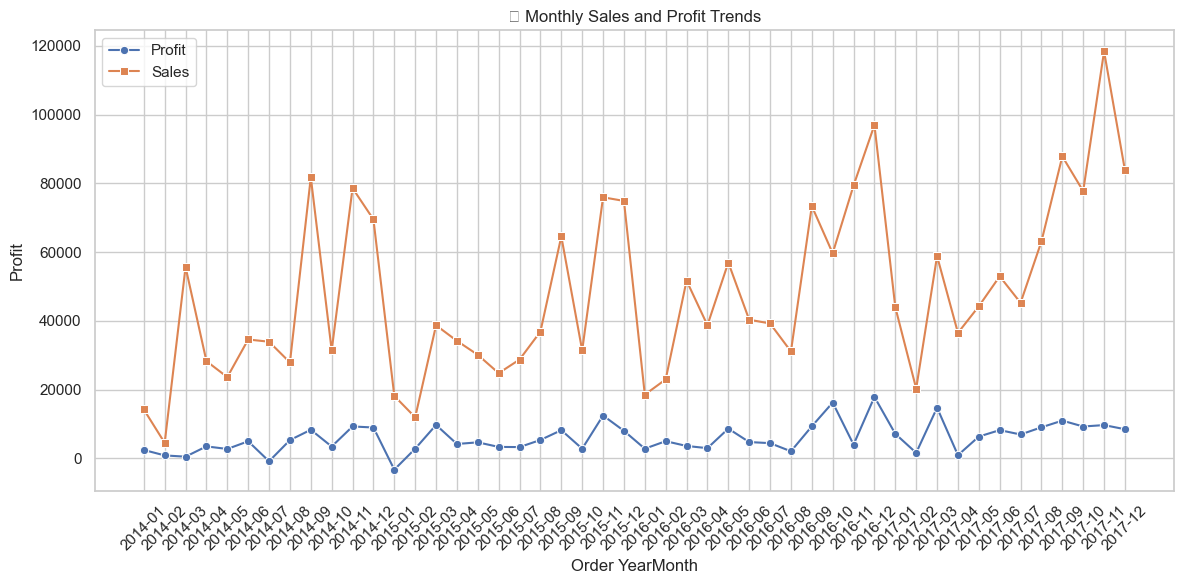

C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\488400570.py:52: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\padmavathi\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


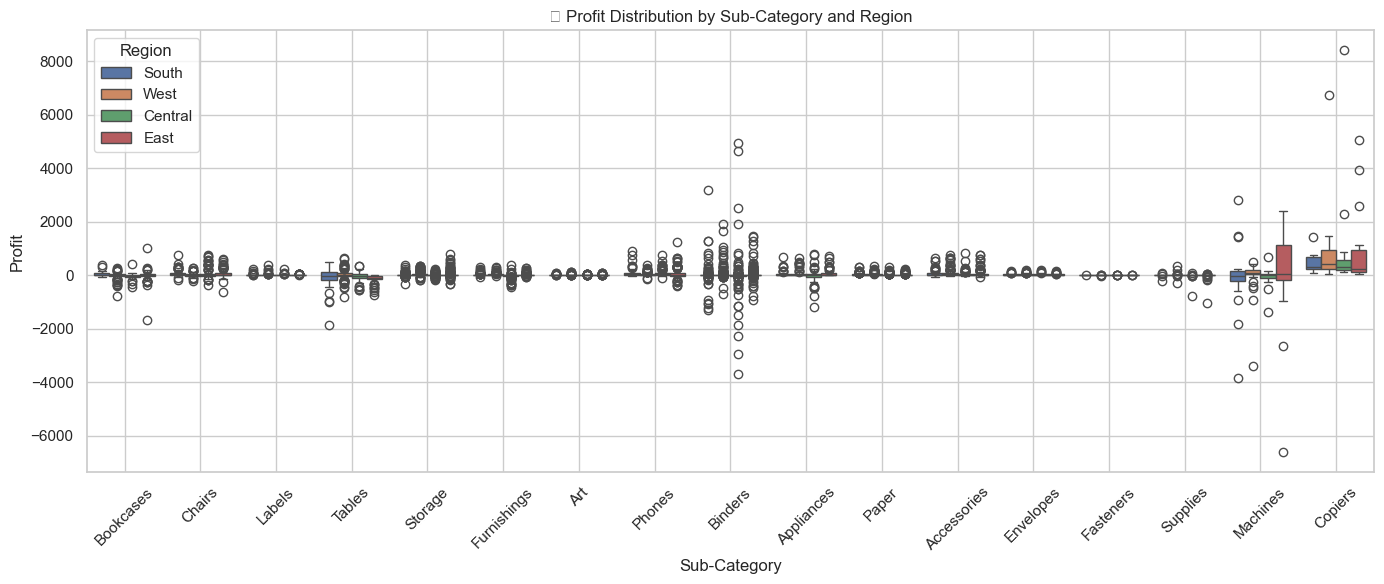

C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\488400570.py:60: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\madhugula padmavathi\AppData\Local\Temp\ipykernel_1624\488400570.py:60: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\padmavathi\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\padmavathi\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


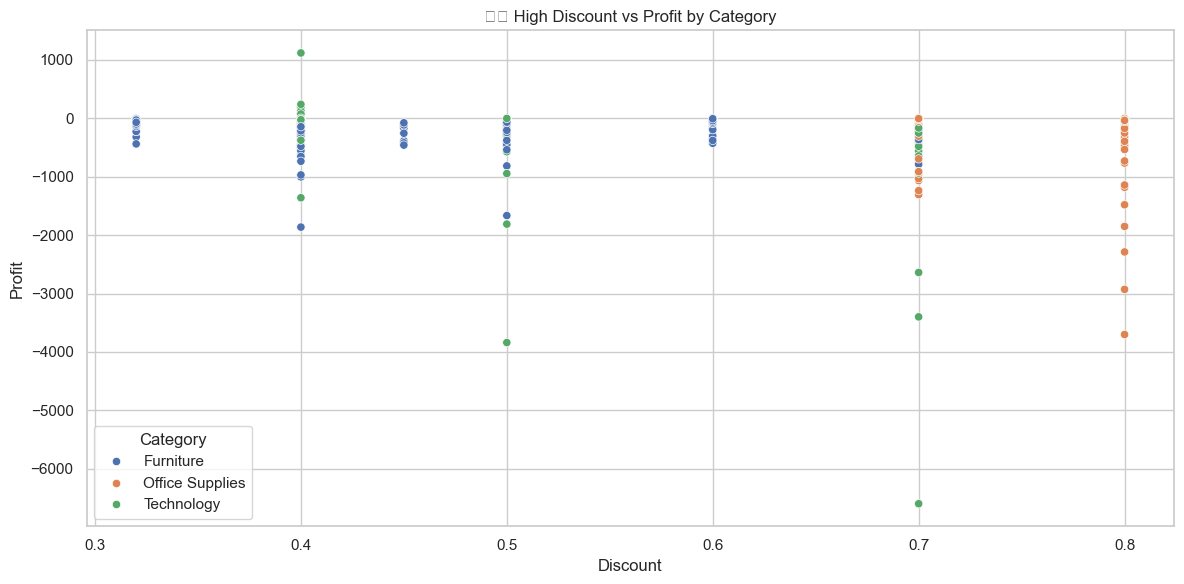


📌 Insights:
1. Strong negative correlation between Discount and Profit.
2. West region generates highest profits overall.
3. Monthly trends show seasonal spikes in sales.
4. Some Sub-Categories like 'Tables' consistently result in losses.
5. High discount rates reduce profit significantly.


In [8]:
# 📘 Day 3: Multivariate & Temporal Analysis - Global Superstore EDA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plot settings
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (12, 6)

# ✅ Load cleaned dataset
cleaned_path = r"C:/Users/padmavathi/solar_demo/superstore_data/cleaned_superstore.csv"
df = pd.read_csv(cleaned_path, parse_dates=['Order Date', 'Ship Date'])

# ✅ Create Order Year-Month column for time analysis
df['Order YearMonth'] = df['Order Date'].dt.to_period('M').astype(str)

# ✅ Multivariate: Category + Region vs Profit
pivot_profit = df.pivot_table(index='Category', columns='Region', values='Profit', aggfunc='sum')
sns.heatmap(pivot_profit, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("📊 Profit by Category and Region")
plt.ylabel("Category")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ Correlation Heatmap (Numerical features)
numeric_cols = ['Sales', 'Quantity', 'Discount', 'Profit']
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔗 Correlation Heatmap")
plt.show()

# ✅ Profit Trend Over Time (Line Plot)
df_monthly = df.groupby('Order YearMonth')[['Sales', 'Profit']].sum().reset_index()
sns.lineplot(data=df_monthly, x='Order YearMonth', y='Profit', label='Profit', marker='o')
sns.lineplot(data=df_monthly, x='Order YearMonth', y='Sales', label='Sales', marker='s')
plt.title("📈 Monthly Sales and Profit Trends")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Profit Distribution by Sub-Category and Region
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Sub-Category', y='Profit', hue='Region')
plt.title("📦 Profit Distribution by Sub-Category and Region")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ High Discount Impact on Profit
high_discount = df[df['Discount'] > 0.3]
sns.scatterplot(data=high_discount, x='Discount', y='Profit', hue='Category')
plt.title("⚠️ High Discount vs Profit by Category")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📝 Key Insight Summary (optional print)
print("\n📌 Insights:")
print("1. Strong negative correlation between Discount and Profit.")
print("2. West region generates highest profits overall.")
print("3. Monthly trends show seasonal spikes in sales.")
print("4. Some Sub-Categories like 'Tables' consistently result in losses.")
print("5. High discount rates reduce profit significantly.")
